# MLB Test Model

Install necessary packages with pip

In [1]:
%pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.


Load the excel file and convert to a dataframe

In [2]:
import pandas as pd

file = "MLB TEST MODEL.xlsx"
df = pd.read_excel(file)
df

,Team,Home/Away,Odds,Value,Units,Result,Winnings
0,Brewers,Away,130,0.079791,0.4,L,-0.400000
1,Phillies,Away,-170,0.027656,0.1,W,0.058824
2,Royals,Home,-125,0.006640,0.1,L,-0.100000
3,Reds,Home,-104,0.007431,0.1,L,-0.100000
4,White Sox,Home,134,0.036540,0.2,W,0.268000
...,...,...,...,...,...,...,...
711,Dodgers,Home,-178,0.010602,0.1,W,0.056180
712,Tigers,Home,-290,0.042407,0.2,P,0.000000
713,Twins,Away,108,0.132798,1.5,L,-1.500000
714,Mets,Away,160,0.025183,0.1,L,-0.100000


Making sure that all the results are valid

In [3]:
possibleResults = ['W', 'L', 'P']
validResults = df['Result'].isin(possibleResults).all()
validResults

np.True_

I want to check if the model overall is profitable (no team-specific analysis)

In [4]:
unitsSum = df['Units'].sum()
print(f"Sum of units: {unitsSum}")
winningsSum = df['Winnings'].sum()
print(f"Sum of winnings: {winningsSum}")

Sum of units: 275.20000000000005
Sum of winnings: -0.7379246816197238


This shows that the model has risked around 275 units and the net profit is around -0.74 units. This means that the model has not made any profit, it has lost money.

We can calculate the ROI (return on investment) using that data:
* Total units risked: ~275.2
* Net profit: -0.74 units

$$
\text{ROI} = \frac{-0.74}{275.2} = -0.27\%
$$

**ROI: ~ -0.27%**


Now I want to check the number of `'W', 'L', 'P'` respectively

In [5]:
df['Result'].value_counts()

Result
W    369
L    334
P     13
Name: count, dtype: int64

<i>
For me:

'P' -> Push (bet is not a win or a loss)<br>
Ex: You bet on under 8.0 runs and the game ends on exactly 8 runs
</i>

So we can see that the number of wins are actually greater than the number of losses (based on the results above). But since the net profit (based on units) is a negative number, then my initial hypothesis is that it means that the losses are more costly since we are risking more for the bets that we lost.

So, my hypothesis is that the bet sizing is wrong. We are risking too much on the bets that we lose. This can be a result of the confidence being wrong.

We are calculating the average unit size for wins vs losses to test my hypothesis. (We want to see if the losses are more costly and if we are wagering too much for some of our losses)

In [10]:
avgUnitSizeWin = df[df['Result'] == 'W']['Units'].mean()
print(f"Average unit size for wins: {avgUnitSizeWin}")

avgUnitSizeLoss = df[df['Result'] == 'L']['Units'].mean()
print(f"Average unit size for losses: {avgUnitSizeLoss}")

Average unit size for wins: 0.38346883468834686
Average unit size for losses: 0.3847305389221557


This surprised me. We see that the average unit size for the winning and losing bets are nearly identical (~ 0.38 units). This suggests that the model's bet sizing based on units is quite consistent and not the issue in this case. But since the model ends up on a net loss, we have to see the model's value and analyze that. We have to see if the model is betting on plays/ games that appear to be profitable but are not in reality. (Plays that don't turn out as expected) 

I want to check if bets with higher value actually perform better. We will plot out the correlation to see.

If the model assigns a high value, it expects that bet to be more profitable. So we expect those bets to win more often and have a high ROI. If they don't, then the model might be overconfident or miscalibrated.

In [13]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [16]:
valueCutoffs = [-float('inf'), 0.02, 0.05, 0.1, float('inf')]

valueLabels = ['Low', 'Medium', 'High', 'Very High']

valueGroups = pd.cut(df['Value'], bins=valueCutoffs, labels=valueLabels)

roiResults = {}

for group in valueLabels:
    groupRows = df[valueGroups == group]
    totalWinnings = groupRows['Winnings'].sum()
    totalUnits = groupRows['Units'].sum()
    roi = totalWinnings / totalUnits if totalUnits != 0 else 0
    roiResults[group] = roi

for group, roi in roiResults.items():
    print(f"ROI for {group} value bets: {roi:.4f}")

ROI for Low value bets: -0.0185
ROI for Medium value bets: -0.0360
ROI for High value bets: -0.0186
ROI for Very High value bets: 0.0156


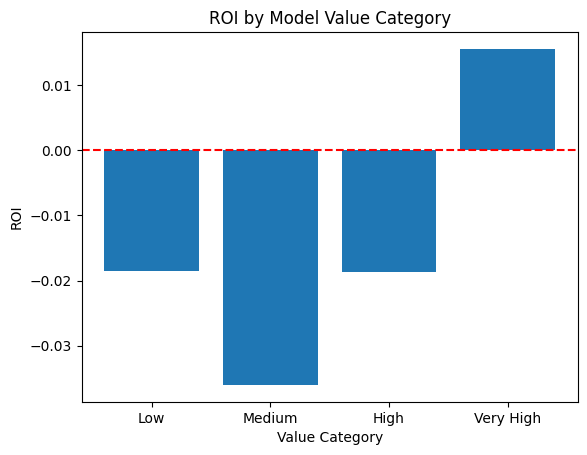

In [17]:
import matplotlib.pyplot as plt

groups = list(roiResults.keys()) 
rois = list(roiResults.values()) 

plt.bar(groups, rois)
plt.axhline(0, color='red', linestyle='--')
plt.title('ROI by Model Value Category')
plt.xlabel('Value Category')
plt.ylabel('ROI')
plt.show()

The graph shows us that the 'Very High' value bets are the only ones that show a positive return. The rest of the value bets ('Low', 'Medium', and 'High') all resulted in a loss. This suggests that the model's confidence can predict some bets but it struggles to make consistent profits on bets of low, medium, or high confidence. So, we can see what we need to do for improving the model's calibration and unit sizing strategies. We want to reduce the losses on bets with lower confidence.

1. The model seems to be too aggressive when it comes to its bets that end up losing. We see that the win rate is higher than the lose rate. So, the losses are due to the model having an overconfident **value** estimate. Its confidence level is not very good when it comes to these losing bets. This influences the model's unit sizing. It ends up putting bigger unit sizes at risk. Some things we can do to help mitigate this issue are capping the maximum bet sizes, especially on bets with uncertain ROI or ones which have a historically bad ROI. 

2. I believe I would be a good fit for your startup team because of my passion for both sports and computer science. I have always been interested in combining the two in a meaningful way, where we can apply it to a real-world profitable scenario. I also have recently been trying to do some computer science related projects with sports. I found a Medium article about NBA data analysis and have been trying to learn how to build models using this data. I plan on making a soccer and basketball match predictor in the near future. My friends are also really into sports and placing bets so I hope that what I create can also help them as well. My primary sports interests have been soccer and basketball/ the NBA. But, I am also open to working with other sports. I think exploring NBA totals and player props would interest me. I think we can use historical data based on player and team to accomplish this. For live betting algorithms, I think this would require some research and some fast-pace algorithms that can accomplish this quickly since these are relying on real-time situations. In soccer, the unders/ expected goals would also interest me since it would require doing some analysis on teams and the players and their performances.